# Importation des librairies nécessaires

In [3]:
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [171]:
import pandas as pd
import numpy as np
import requests
import cartiflette.s3 as s3
import geopandas as gpd
from shapely.geometry import shape
from io import StringIO
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Importation des bases de données

## Importation des bases de données via API de l'OpenDataSoft

L'éxécution de la requête API prend assez de temps

In [58]:
def get_data_ODS(dataset_name):
    """
    Fonction qui permet de récupérer des données via l'API d'OpenDataSoft
    Elle retourne un dataframe
    
    """
    df = pd.DataFrame()
    # URL de base pour accéder à l'API d'ODS
    base_url_ODS = "https://odre.opendatasoft.com/api/explore/v2.1"
    
    dataset_path = f"/catalog/datasets/{dataset_name}/exports/json?lang=fr&timezone=Europe%2FBerlin"
    url = f"{base_url_ODS}{dataset_path}"
    
    # Exécution de la requête GET
    
    response = requests.get(url)
    # Vérification si la requête a réussi
    if response.status_code == 200:
        # Extraction des données
        data = response.json()
        # Conversion des résultats en DataFrame
        df = pd.DataFrame(data)
    else:
        print(f"Erreur lors de la requête: {response.status_code}")

    return df


def get_data_ODSW(dataset_name, output = "json"):
    """
    Fonction qui permet de récupérer des données via l'API  publique d'OpenDataSoft
    Elle retourne un dataframe
    
    """
    df = pd.DataFrame()
    # URL de base pour accéder à l'API d'ODS
    base_url_ODS = "https://public.opendatasoft.com/api/explore/v2.1"
    
    dataset_path = f"/catalog/datasets/{dataset_name}/exports/{output}?lang=fr&timezone=Europe%2FBerlin"
    url = f"{base_url_ODS}{dataset_path}"
    
    # Exécution de la requête GET
    response = requests.get(url)
    # Vérification si la requête a réussi
    if response.status_code == 200:
        # Extraction des données
        if output == "json":
            data = response.json()
            # Conversion des résultats en DataFrame
            df = pd.DataFrame(data)
        else:
            data = response.json()
            geometries = [shape(feature['geometry']) for feature in data['features']]
            properties = [feature['properties'] for feature in data['features']]
    
            # Créer un GeoDataFrame en combinant les géométries et les propriétés
            df = gpd.GeoDataFrame(geometry=geometries, data=properties)
    else:
        print(f"Erreur lors de la requête: {response.status_code}")

    return df

In [5]:
consumption_dataset_name = "consommation-quotidienne-brute-regionale"
weather_dataset_name = "donnees-synop-essentielles-omm"
holiday_dataset_name = "jours-ouvres-week-end-feries-france-2010-a-2030"
data_consumption = get_data_ODS(consumption_dataset_name)
data_weather = get_data_ODSW(weather_dataset_name)
holiday_dataset = get_data_ODSW(holiday_dataset_name)

## Import d'une base de données complémentaire (celle des régions, communes, et départements de France

Cette importation va se faire à travers une requête via l'API de Datagouv

In [6]:
#Identifiant du dataset
dataset_id = "4a7c837bb6da8e363604082bcc8b2e504cf08038"
dataset_sha1 = "dbe8a621-a9c4-4bc3-9cae-be1699c5ff25"

# URL de base pour accéder à l'API
base_url = "https://www.data.gouv.fr/api/1/"

# Chemin pour accéder aux enregistrements du dataset
dataset_path = f"datasets/r/{dataset_sha1}?dataset={dataset_id}"

# Construction de l'URL complète
url = f"{base_url}{dataset_path}"

# Exécution de la requête GET
response = requests.get(url)

# Vérification si la requête a réussi
if response.status_code == 200:
    # Lecture du contenu CSV
    data_communes = pd.read_csv(StringIO(response.content.decode('utf-8')))
else:
    print(f"Erreur lors de la requête: {response.status_code}")

On enregistre les bases de données importées pour ne plus avoir à éxécuter la requête API à chaque étape

In [7]:
data_consumption.to_csv('data_consumption.csv', index=False)
data_communes.to_csv('data_communes.csv', index=False)
data_weather.to_csv('data_weather.csv', index = False)
#data_geo.to_file("data_geo.geojson", driver='GeoJSON')

Code permettant de charger les bases de données précédemment enregistrées:

In [6]:
data_consumption = pd.read_csv('data_consumption.csv')
data_communes = pd.read_csv('data_communes.csv')
data_weather = pd.read_csv('data_weather.csv')

## Suppression des données répétées dans les bases

In [ ]:
# code de suppression ici

# À quoi sert le code ci-dessous ?

In [9]:
dep = s3.download_vectorfile_url_all(
    values = "metropole",
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="topojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=DEPARTEMENT/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 7.17MiB [00:00, 92.1MiB/s]


Les dataframes de consommation et météorologiques  étant sous forme de séries temporelles, on place les dates en index.

In [8]:
data_consumption['datetime'] = pd.to_datetime(data_consumption['date'] + ' ' + data_consumption['heure'])
data_consumption.set_index('datetime', inplace=True)

In [10]:
data_consumption.head()

,date_heure,date,heure,code_insee_region,region,consommation_brute_gaz_grtgaz,statut_grtgaz,consommation_brute_gaz_terega,statut_terega,consommation_brute_gaz_totale,consommation_brute_electricite_rte,statut_rte,consommation_brute_totale
datetime,,,,,,,,,,,,,
2013-01-03 00:00:00,2013-01-03T00:00:00+01:00,2013-01-03,00:00,32,Hauts-de-France,8481.0,Définitif,NaN,NaN,8481.0,6541,Définitif,15022.0
2013-01-03 00:00:00,2013-01-03T00:00:00+01:00,2013-01-03,00:00,44,Grand Est,8645.0,Définitif,NaN,NaN,8645.0,5731,Définitif,14376.0
2013-01-03 00:00:00,2013-01-03T00:00:00+01:00,2013-01-03,00:00,75,Nouvelle-Aquitaine,2553.0,Définitif,2247.0,Définitif,4800.0,6114,Définitif,10914.0
2013-01-03 00:30:00,2013-01-03T00:30:00+01:00,2013-01-03,00:30,11,Île-de-France,NaN,NaN,NaN,NaN,NaN,9630,Définitif,NaN
2013-01-03 00:30:00,2013-01-03T00:30:00+01:00,2013-01-03,00:30,53,Bretagne,NaN,NaN,NaN,NaN,NaN,3161,Définitif,NaN


Choix de l'année

In [11]:
annee_choisie = 2019
data_consumption = data_consumption[data_consumption.index.year == annee_choisie]


In [12]:
col_del = pd.Index(['date_heure', 'consommation_brute_gaz_grtgaz', 'statut_grtgaz', 'consommation_brute_gaz_terega', 'statut_terega','consommation_brute_gaz_totale','statut_rte', 'consommation_brute_totale'])
data_consumption.drop(col_del, axis=1,inplace=True)
data_consumption.isna().sum()

date                                  0
heure                                 0
code_insee_region                     0
region                                0
consommation_brute_electricite_rte    0
dtype: int64

## Aggrégation des consommations par date et par région

In [13]:
data_consumption1 = data_consumption.groupby(['code_insee_region','date'], as_index = False)
data_consumption1 = data_consumption1['consommation_brute_electricite_rte'].sum()
data_consumption1.set_index("date", inplace=True)

### Calcul des superficies par département

Les superficies seront utiles pour l'agrégation des variables météorologiques.

### Calcul de la superficie

In [14]:
dep["superficie"] = dep.to_crs(2154).area

### Traitement de la base weather

In [15]:
nouveaux_noms_colonnes={'numer_sta':'num_station', 'date':'date_UTC', 'pmer':'pression_mer', 'tend':'variation_pression_3h', 'cod_tend':'type_tendance_baro', 'dd':'direction_vent', 'ff':'vitesse_vent', 't':'temperature', 'td':'point_de_rosee',
       'u':'humidite', 'vv':'visibilite_horizontale', 'ww':'temps_present', 'w1':'temps_passe_1', 'w2':'temps_passe_2', 'n':'nebulosite_totale', 'nbas':'nebulosite_nuage_etage_inf', 'hbas':'hauteur_base_nuage_etage_inf', 'cl':'type_nuage_etage_inf', 'cm':'type_nuage_etage_moyen', 'ch':'type_nuage_etage_sup',
       'pres':'pression_station', 'niv_bar':'niveau_barometriq', 'geop':'geopotentiel', 'tend24':'variation_pression_24h', 'tn12':'temperature_min_sur_12h', 'tn24':'temperature_min_sur_24h', 'tx12':'temperature_max_sur_12h', 'tx24':'temperature_max_sur_24h',
       'tminsol':'temperature_min_sol_sur_12h', 'sw':'methode_mesure_temperature_thermometre_mouille', 'tw':'temperature_thermometre_mouille', 'raf10':'rafales_10_dernieres_minutes', 'rafper':'rafales_sur_une_periode', 'per':'periode_mesure_rafales', 'etat_sol':'etat_du_sol', 'ht_neige':'hauteur_totale_couche_neige/glace_au_sol',
       'ssfrai':'hauteur_neige_fraiche', 'perssfrai':'periode_mesure_neige_fraiche', 'rr1':'precipitation_dans_1_derniere_heure', 'rr3':'precipitation_dans_3_derniere_heure', 'rr6':'precipitation_dans_6_derniere_heure', 'rr12':'precipitation_dans_12_derniere_heure', 'rr24':'precipitation_dans_24_derniere_heure', 'phenspe1':'phenomene_special_1',
       'phenspe2':'phenomene_special_2', 'phenspe3':'phenomene_special_3', 'phenspe4':'phenomene_special_4', 'nnuage1':'nebulosite_couche_nuageuse_1', 'ctype1':'type_de_nuage_1', 'hnuage1':'hauteur_de_base_nuage_1',
       'nnuage2':'nebulosite_couche_nuageuse_2', 'ctype2':'type_de_nuage_2', 'hnuage2':'hauteur_de_base_nuage_2', 'nnuage3':'nebulosite_couche_nuageuse_3', 'ctype3':'type_de_nuage_3', 'hnuage3':'hauteur_de_base_nuage_3',
       'nnuage4':'nebulosite_couche_nuageuse_4', 'ctype4':'type_de_nuage_4', 'hnuage4':'hauteur_de_base_nuage_4', 'coordonnees':'coordonnees', 'nom':'nom_commune',
       'type_de_tendance_barometrique':'type_de_tendance_barometrique', 'temps_passe_1':'temps_passe_1', 'temps_present':'temps_present', 'tc':'temperature_degre_celcius',
       'tn12c':'temperature_celcius_min_sur_12h', 'tn24c':'temperature_celcius_min_sur_24h', 'tx12c':'temperature_celcius_max_sur_12h', 'tx24c':'temperature_celcius_max_sur_24h', 'tminsolc':'temperature_celcius_min_sol_sur_12h', 'latitude':'latitude', 'longitude':'longitude',
       'altitude':'altitude', 'libgeo':'libelle_geolocalisation', 'codegeo':'code_geolocalisation', 'nom_epci':'nom_EPCI', 'code_epci':'code_EPCI', 'nom_dept':'nom_departement',
       'code_dep':'code_departement', 'nom_reg':'nom_region', 'code_reg':'code_region', 'mois_de_l_annee':'mois'}

In [16]:
base_meteo_modifie_1 = data_weather.rename(columns=nouveaux_noms_colonnes)

## Identification des variables météoroliques à retenir

Il est question d'identifier les les variables météorologiques se reférant aux espects retenus Après une revue de la littérature:
* __Température :__ les variables identifiées sont la température en degré celcius ('temperature_degre_celcius'), la température minimale sur les 24 dernières heures ('temperature_celcius_min_sur_24h'), et la température maximale sur les 24 dernières heures ('temperature_celcius_max_sur_24h')
* __Vitesse du vent :__ la variable identifiée est la vitesse du vent ('vitesse_vent')
* __Couverture nuageuse :__ la variable identifié est la nébulosité totale et renvoie à la quantité totale de nuages couvrant le ciel ou plus simplement le degré de couverture nuageuse dans le ciel ('nebulosite_totale')
* __Humidité :__ la variable identifiée est l'indice d'humidité ('humidite')
* __Rayonnement global :__ la variable identifiée pour capter cet aspect est la distance maximale à laquelle des objets peuvent être clairement discernés à l'horizon ('visibilite_horizontale')

In [17]:
weather_vars = ['num_station', 'date_UTC', 'vitesse_vent', 'temperature','nebulosite_totale','temperature_degre_celcius', 'temperature_celcius_min_sur_24h', 'temperature_celcius_max_sur_24h','latitude', 'longitude','altitude', 'libelle_geolocalisation', 'code_geolocalisation','nom_departement', 'code_departement','nom_region', 'code_region', 'mois', 'visibilite_horizontale', 'coordonnees','nom_commune',]
base_meteo_modifie_1 = base_meteo_modifie_1[weather_vars]

### Vérification et gestion des valeurs manquantes pour les variables d'agrégation

#### Vérification des régions et départements manquants

In [18]:
print("Nombre de nom_regions manquants :", base_meteo_modifie_1['nom_region'].isnull().sum())
print("Nombre de code_regions manquants :", base_meteo_modifie_1['code_region'].isnull().sum())
print("Nombre de nom_departements manquants :", base_meteo_modifie_1['nom_departement'].isnull().sum())
print("Nombre decode_departements  manquants :", base_meteo_modifie_1['code_departement'].isnull().sum())
print("Nombre de nom_communes manquants :", base_meteo_modifie_1['nom_commune'].isnull().sum())

Nombre de nom_regions manquants : 243205
Nombre de code_regions manquants : 243205
Nombre de nom_departements manquants : 243205
Nombre decode_departements  manquants : 243205
Nombre de nom_communes manquants : 0


On constate que tous les noms de commune sont renseignés, mais certains noms de région et département ne le sont pas. Nous allons donc utiliser les noms de commune pour renseigner les départements et régions manquants.

Nous explorons la possibilité de completer les régions et départements manquants à partir de la base de données des communes, régions et départements.

In [19]:
data_communes.isna().sum()

code_commune_INSEE          0
nom_commune_postal          0
code_postal                 0
libelle_acheminement        0
ligne_5                 35944
latitude                  269
longitude                 269
code_commune                7
article                 36621
nom_commune                 0
nom_commune_complet         0
code_departement            7
nom_departement           267
code_region               267
nom_region                267
dtype: int64

Le dataset des communes possède lui même des valeurs manquantes au niveau des codes de département et de région. Nous allons compléter ces valeurs manquantes en utilisant les combinaisons "code_commune - code_departement - code-region" les plus fréquentes. Puis nous allons le joindre avec le dataset de météo.

In [20]:
combinaisons_frequentes = data_communes.groupby(['code_commune', 'code_departement', 'code_region']).size().idxmax()

# Imputer les valeurs manquantes dans 'longitude' et 'latitude' en fonction des combinaisons les plus fréquentes
data_communes['code_departement'].fillna(combinaisons_frequentes[1], inplace=True)
data_communes['code_region'].fillna(combinaisons_frequentes[2], inplace=True)

In [21]:
combi_freq = base_meteo_modifie_1.groupby(['latitude', 'longitude', 'libelle_geolocalisation']).size().idxmax()

# Imputer les valeurs manquantes dans 'longitude' et 'latitude' en fonction des combinaisons les plus fréquentes
base_meteo_modifie_1['libelle_geolocalisation'].fillna(combi_freq[2], inplace=True)

Cela étant fait, comme le dataset weather possède les noms de communes (la colonne "nom_commune"), qui est déjà presqu'harmonisée avec la colonne des noms de communes du dataset de communes (nom_commune_complet). On complète alors l'hamonisation et on peut donc faire une fusion sur les noms de communes.

Harmonisation

In [22]:
base_meteo_modifie_1.isna().sum()

num_station                              0
date_UTC                                 0
vitesse_vent                         27007
temperature                          15388
nebulosite_totale                  1207332
temperature_degre_celcius            15388
temperature_celcius_min_sur_24h    2148469
temperature_celcius_max_sur_24h    2149352
latitude                                 0
longitude                                0
altitude                                 0
libelle_geolocalisation                  0
code_geolocalisation                243205
nom_departement                     243205
code_departement                    243205
nom_region                          243205
code_region                         243205
mois                                     0
visibilite_horizontale              549625
coordonnees                              0
nom_commune                              0
dtype: int64

In [23]:
base_meteo_modifie_1['libelle_geolocalisation'] = base_meteo_modifie_1['libelle_geolocalisation'].apply(lambda x: x.replace("Saint-Pierre", "St pierre").replace("Saint-Barthélemy", "St barthelemy") if isinstance(x, str) else x)

In [24]:
#Vérifions que les noms sont bien harmonisés
a = pd.DataFrame()
for elt in list(base_meteo_modifie_1['libelle_geolocalisation'].unique()):
    if "cod_geo" in a.columns:
        if not data_communes[data_communes['nom_commune_complet']==elt].empty:
            nvo = {"lib_geo" : elt, "cod_geo" : base_meteo_modifie_1[base_meteo_modifie_1['libelle_geolocalisation'] == elt ]['code_geolocalisation'].iloc[0], "nom_com" :data_communes[data_communes['nom_commune_complet']==elt]["nom_commune_complet"].iloc[0], "cod_com" : data_communes[data_communes['nom_commune_complet']==elt]["code_commune_INSEE"].iloc[0], "nom_dep": data_communes[data_communes['nom_commune_complet']==elt]["nom_departement"].iloc[0], "nom_reg" : data_communes[data_communes['nom_commune_complet']==elt]["nom_region"].iloc[0]}
            a = pd.concat([a, pd.DataFrame([nvo])], ignore_index=True)
    else:
        a["lib_geo"] = elt
        a["cod_geo"] = base_meteo_modifie_1[base_meteo_modifie_1['libelle_geolocalisation'] == elt ]['code_geolocalisation'][0]
        if not data_communes[data_communes['code_commune_INSEE']==elt].empty:
            a["nom_com"] = data_communes[data_communes['nom_commune_complet']==elt]["nom_commune_postal"].iloc[0]
            a["cod_com"] = data_communes[data_communes['nom_commune_complet']==elt]["code_commune_INSEE"].iloc[0]
            a["nom_dep"] = data_communes[data_communes['nom_commune_complet']==elt]["nom_departement"].iloc[0]
            a["nom_reg"] = data_communes[data_communes['nom_commune_complet']==elt]["nom_region"].iloc[0]

a['resultat_comparaison'] = a['lib_geo'] == a['nom_com']
a

,lib_geo,cod_geo,nom_com,cod_com,nom_dep,nom_reg,resultat_comparaison
0,Carpiquet,14137,Carpiquet,14137,Calvados,Normandie,True
1,Thuilley-aux-Groseilles,54523,Thuilley-aux-Groseilles,54523,Meurthe-et-Moselle,Grand Est,True
2,Perpignan,66136,Perpignan,66136,Pyrénées-Orientales,Occitanie,True
3,Bangor,56009,Bangor,56009,Morbihan,Bretagne,True
4,Poitiers,86194,Poitiers,86194,Vienne,Nouvelle-Aquitaine,True
5,Limoges,87085,Limoges,87085,Haute-Vienne,Nouvelle-Aquitaine,True
6,Louey,65284,Louey,65284,Hautes-Pyrénées,Occitanie,True
7,Marignane,NaN,Marignane,13054,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,True
8,La Trinité,97230,La Trinité,6149,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,True
9,Athis-Mons,91027,Athis-Mons,91027,Essonne,Île-de-France,True


### Jointure des bases communes et weather

In [25]:
data_communes = data_communes.drop_duplicates(subset='nom_commune_complet', keep='first')

In [26]:
base_meteo_modifie_1 = pd.merge(base_meteo_modifie_1, data_communes, left_on='libelle_geolocalisation', right_on="nom_commune_complet",  how='left', validate="m:1")

In [27]:
print("Nombre de valeurs uniques de combinaisons latitude - longitude : ", base_meteo_modifie_1.groupby(['latitude_x', 'longitude_x']).size().nunique())
print("Nombre de régions couvertes : ", base_meteo_modifie_1['nom_region_x'].nunique())
print("Nombre de communes renseignées dans la base: ", base_meteo_modifie_1['nom_commune_x'].nunique())

Nombre de valeurs uniques de combinaisons latitude - longitude :  61
Nombre de régions couvertes :  21
Nombre de communes renseignées dans la base:  62


Il semble dès lors que la base a couvert toutes les régions de France, mais avec uniquement 61 points de collecte d'informations (à travers toute la France), correspondants à 62 communes. Comme toutes les latitudes et longitudes sont renseignées, à chaque couple (latitude - longitude) correspond un point de collecte, donc une commune, une région et un département. On va donc imputer tout d'abord les communes en fonction de ce qu'il a rencontré sur une autre ligne correspondant à la séquence longitude - latitude - commune, puis imputer département et région par la suite.

In [28]:
# Tri du DataFrame par 'longitude' et 'latitude'
base_meteo_modifie_1.sort_values(['longitude_x', 'latitude_x'], inplace=True)

# Remplir les valeurs manquantes dans 'departement' et région en fonction des combinaisons 'longitude-latitude'
base_meteo_modifie_1['code_departement_x'] = base_meteo_modifie_1.groupby(['longitude_x', 'latitude_x'])['code_departement_x'].transform(lambda x: x.ffill().bfill())
base_meteo_modifie_1['code_region_x'] = base_meteo_modifie_1.groupby(['longitude_x', 'latitude_x'])['code_region_x'].transform(lambda x: x.ffill().bfill())

In [29]:
base_meteo_modifie_1['code_departement_y'] = base_meteo_modifie_1.groupby(['longitude_y', 'latitude_y'])['code_departement_y'].transform(lambda x: x.ffill().bfill())
base_meteo_modifie_1['code_region_y'] = base_meteo_modifie_1.groupby(['longitude_y', 'latitude_y'])['code_region_y'].transform(lambda x: x.ffill().bfill())

In [30]:
b = base_meteo_modifie_1[base_meteo_modifie_1['code_departement_y'].isna()]
b["nom_commune_complet"].nunique()

2

### Suppression des communes hors de la France Metropolitaine

A présent il y'a un problème sur St Barthelemy, et sur les communes françaises qui ne sont pas en France métropolitaine. 
Pour celles qui ne sont pas en France Métropolitaine, on va tout simplement les supprimer;

In [31]:
base_meteo_modifie_1 = base_meteo_modifie_1.dropna(subset=['nom_commune_complet'])
base_meteo_modifie_1 = base_meteo_modifie_1[~ (base_meteo_modifie_1['nom_commune_complet'] == 'St barthelemy')]
base_meteo_modifie_1 = base_meteo_modifie_1[~ (base_meteo_modifie_1['nom_commune_complet'] == 'St pierre')]

In [32]:
base_meteo_modifie_1.isna().sum()

num_station                              0
date_UTC                                 0
vitesse_vent                         22672
temperature                          14803
nebulosite_totale                  1146299
temperature_degre_celcius            14803
temperature_celcius_min_sur_24h    2113316
temperature_celcius_max_sur_24h    2113990
latitude_x                               0
longitude_x                              0
altitude                                 0
libelle_geolocalisation                  0
code_geolocalisation                243205
nom_departement_x                   243205
code_departement_x                  157511
nom_region_x                        243205
code_region_x                       157511
mois                                     0
visibilite_horizontale              491183
coordonnees                              0
nom_commune_x                            0
code_commune_INSEE                       0
nom_commune_postal                       0
code_postal

In [33]:
base_meteo_modifie_1.drop(['nom_departement_x', 'code_departement_x','nom_region_x', 'code_region_x','latitude_x', 'longitude_x','nom_commune_x'], axis=1, inplace=True)
base_meteo_modifie_1.rename(columns={'latitude_y': 'latitude', 'longitude_y':'longitude','nom_commune_y': 'nom_commune', 'code_departement_y' : 'code_departement', 'nom_departement_y': 'nom_departement', 'code_region_y' : 'code_region', 'nom_region_y':'nom_region'}, inplace=True)

## Agrégation des variables météorologiques

In [34]:
base_meteo_modifie_2=base_meteo_modifie_1

Il est ici question de construire les variables qui seront utilisées dans les analyses. Les données seront agrégées au niveau régional et à une fréquence journalière.

Définition d'une fonction permettant d'extraire une une partie d'une chaine de caractère en indiquant les positions de début et de fin.

In [35]:
def extraire_sous_chaine(chaine, debut, fin):
    """
    Extrait la sous-chaîne de 'debut' à 'fin' (inclus) de la chaîne donnée.
    """
    if debut < 0 or fin >= len(chaine):
        raise ValueError("Indices de début ou de fin invalides.")
    return chaine[debut : fin + 1]

Nous appliquons la fonction à la base:

In [36]:
base_meteo_modifie_2['jour']=base_meteo_modifie_2['date_UTC'].apply(extraire_sous_chaine,debut=0,fin=9)
base_meteo_modifie_2['heure']=base_meteo_modifie_2['date_UTC'].apply(extraire_sous_chaine,debut=11,fin=18)

## Agrégation des variables à l'échelle départementale

Tout d'abord, agrégeons les variables 'temperature_degre_celcius','vitesse_vent', 'nebulosite_totale', 'humidite', 'visibilite_horizontale'

In [37]:
agregation_dep_mean = base_meteo_modifie_2.groupby(['jour','code_departement'], as_index=False).agg({'temperature_degre_celcius': 'mean', 'vitesse_vent': 'mean','nebulosite_totale':'mean','visibilite_horizontale':'mean'})
agregation_dep_mean = agregation_dep_mean.rename(columns={'jour':'jour','code_departement':'code_departement','temperature_degre_celcius':'temperature_degre_celcius_departement','vitesse_vent':'vitesse_vent_departement','nebulosite_totale':'nebulosite_totale_departement','visibilite_horizontale':'visibilite_horizontale_departement'})

In [38]:
base_meteo_modifie_3 = pd.merge(base_meteo_modifie_2, agregation_dep_mean, on=['jour','code_departement'], how='left')

In [39]:
dep.rename(columns={'INSEE_DEP': 'code_departement'}, inplace=True)
dep['code_departement'] = dep['code_departement'].astype(str)
base_meteo_modifie_4 = dep.merge(base_meteo_modifie_3, on='code_departement')
#base_meteo_modifie_4 = gpd.GeoDataFrame(pd.merge(base_meteo_modifie_3, data_geo, on=['code_departement'], how='left'),  geometry='geometry')

In [40]:
agregation_dep_mean.head()

,jour,code_departement,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement
0,2010-01-01,10,0.750000,4.86250,100.000000,5250.000000
1,2010-01-01,12,2.825000,7.97500,95.000000,3000.000000
2,2010-01-01,13,15.144304,5.73662,56.964286,39766.666667
3,2010-01-01,14,1.400000,2.87500,95.000000,19125.000000
4,2010-01-01,15,25.962500,1.78750,NaN,NaN


### Aggrégation par région en appliquant les pondérations que sont les superficies des départements

Créons un dictionnaire pour stocker les critères d'agrégation

In [41]:
criteres_agregation = {'temperature_degre_celcius_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'vitesse_vent_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'nebulosite_totale_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie']),'visibilite_horizontale_departement': lambda x: np.average(x, weights=base_meteo_modifie_4.loc[x.index, 'superficie'])}

Appliquons l'agrégation groupée en utilisant les critères spécifiés

In [42]:
agregation_reg_mean = base_meteo_modifie_4.groupby(['jour','code_region'], as_index=False).agg(criteres_agregation)

In [43]:
agregation_reg_mean.head()

,jour,code_region,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement
0,2010-01-01,11.0,-0.062500,4.900000,85.714286,13437.500000
1,2010-01-01,24.0,1.424418,3.459109,96.569760,7092.446640
2,2010-01-01,27.0,2.237500,4.237500,89.285714,19625.000000
3,2010-01-01,28.0,2.283775,5.450085,74.496179,17019.038174
4,2010-01-01,32.0,0.238066,4.914637,46.586860,21470.137965


In [44]:
agregation_reg_mean = agregation_reg_mean.rename(columns={'jour':'jour','code_region':'code_region','temperature_degre_celcius_departement':'temperature_degre_celcius_region','vitesse_vent_departement':'vitesse_vent_region','nebulosite_totale_departement':'nebulosite_totale_region','visibilite_horizontale_departement':'visibilite_horizontale_region'})

Fusion de la base agrégée obtenue et de la base de départ dans une nouvelle base

In [45]:
base_meteo_modifie_5 = pd.merge(base_meteo_modifie_4, agregation_reg_mean, on=['jour','code_region'], how='left')

Aperçu de la base obtenue

In [46]:
base_meteo_modifie_5.head()

,id,ID,NOM_M,NOM,code_departement,INSEE_REG,source,territoire,geometry,superficie,...,jour,heure,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement,temperature_degre_celcius_region,vitesse_vent_region,nebulosite_totale_region,visibilite_horizontale_region
0,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,2013-04-06,08:00:00,11.5625,2.6250,87.142857,28812.5,11.656868,2.598038,81.365222,30733.563645
1,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,2013-04-06,20:00:00,11.5625,2.6250,87.142857,28812.5,11.656868,2.598038,81.365222,30733.563645
2,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,2013-04-07,05:00:00,13.0000,2.3125,81.875000,31250.0,13.451618,2.871968,72.101167,22959.093743
3,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,2013-04-07,23:00:00,13.0000,2.3125,81.875000,31250.0,13.451618,2.871968,72.101167,22959.093743
4,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,2013-04-08,17:00:00,12.8000,3.3875,90.000000,13125.0,12.348382,2.659518,88.844473,18382.647870


## Agrégation des autres variables (températures minimales et maximales)

Nous allons considérer que la température minimale/maximale observée avant 22h est la température minimale/maximale de la journée.

Crérons une base des températures minimales
On extrait la base de données pour chaque 22h

In [47]:
base_22h=base_meteo_modifie_2[base_meteo_modifie_2['heure']=='22:00:00']
agregation_reg_min_max=base_22h.groupby(['jour','code_region'], as_index=False).agg({'temperature_celcius_min_sur_24h': 'min', 'temperature_celcius_max_sur_24h': 'max'})
agregation_reg_min_max = agregation_reg_min_max.rename(columns={'jour':'jour','code_region':'code_region','temperature_celcius_min_sur_24h':'temperature_celcius_min_sur_24h_region','temperature_celcius_max_sur_24h':'temperature_celcius_max_sur_24h_region'})

In [ ]:
Aperçu des données agrégée:

In [48]:
agregation_reg_min_max.head()

,jour,code_region,temperature_celcius_min_sur_24h_region,temperature_celcius_max_sur_24h_region
0,2010-01-01,1.0,NaN,NaN
1,2010-01-01,2.0,NaN,NaN
2,2010-01-01,3.0,NaN,NaN
3,2010-01-01,6.0,NaN,NaN
4,2010-01-01,11.0,NaN,NaN


In [49]:
print("proportion de températures minimales manquantes :", agregation_reg_min_max['temperature_celcius_min_sur_24h_region'].isnull().sum()/len(agregation_reg_min_max))
print("proportion de températures maximales manquantes :", agregation_reg_min_max['temperature_celcius_max_sur_24h_region'].isnull().sum()/len(agregation_reg_min_max))

proportion de températures minimales manquantes : 0.882878241456294
proportion de températures maximales manquantes : 0.882878241456294


Pour construire les variables indiquant les températures minimales et maximales, nous avons précédemment considéré que la température minimale/maximale observée avant 22h est la température minimale/maximale de la journée. Toutefois, il est constaté que cette variable comporte trop de valeurs manquantes (plus de 88%). Nous faisons donc le choix de la remplacer par une autre. Désormais, la température minimale/maximale de la journée sera assimilée à la plus petite/grande valeur de température enregistrée dans les stations. Cela comporte bien-sûr des limites dans la mesure où les observations sont faites toutes les 3 heures de temps. Mais nous pensons que c'est mieux que d'avoir une série entièrement imputée.

In [50]:
agregation_reg_min=base_meteo_modifie_5.groupby(['jour','code_region'], as_index=False).agg({'temperature_degre_celcius': 'min'})
agregation_reg_min = agregation_reg_min.rename(columns={'jour':'jour','code_region':'code_region','temperature_degre_celcius':'temperature_celcius_min_sur_24h_region'})
agregation_reg_max=base_meteo_modifie_5.groupby(['jour','code_region'], as_index=False).agg({'temperature_degre_celcius': 'max'})
agregation_reg_max = agregation_reg_max.rename(columns={'jour':'jour','code_region':'code_region','temperature_degre_celcius':'temperature_celcius_max_sur_24h_region'})

Aperçu des nouvelles variables issues de l'agrégation

In [51]:
agregation_reg_min.head()

,jour,code_region,temperature_celcius_min_sur_24h_region
0,2010-01-01,11.0,-3.3
1,2010-01-01,24.0,-1.6
2,2010-01-01,27.0,0.1
3,2010-01-01,28.0,-1.8
4,2010-01-01,32.0,-3.4


In [52]:
agregation_reg_max.head()

,jour,code_region,temperature_celcius_max_sur_24h_region
0,2010-01-01,11.0,0.9
1,2010-01-01,24.0,6.4
2,2010-01-01,27.0,4.9
3,2010-01-01,28.0,5.6
4,2010-01-01,32.0,2.1


In [53]:
print("proportion de températures minimales manquantes :", agregation_reg_min['temperature_celcius_min_sur_24h_region'].isnull().sum()/len(agregation_reg_min_max))
print("proportion de températures maximales manquantes :", agregation_reg_max['temperature_celcius_max_sur_24h_region'].isnull().sum()/len(agregation_reg_min_max))

proportion de températures minimales manquantes : 0.0
proportion de températures maximales manquantes : 0.0


Fusion des bases agrégées obtenues et de la base de départ dans une nouvelle base:

In [73]:
base_meteo_modifie_6 = pd.merge(base_meteo_modifie_5, agregation_reg_min, on=['jour','code_region'], how='left')
base_meteo_modifie_6 = pd.merge(base_meteo_modifie_6, agregation_reg_max, on=['jour','code_region'], how='left')

Aperçu de la nouvelle base obtenue

In [55]:
base_meteo_modifie_6.head()

,id,ID,NOM_M,NOM,code_departement,INSEE_REG,source,territoire,geometry,superficie,...,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement,temperature_degre_celcius_region,vitesse_vent_region,nebulosite_totale_region,visibilite_horizontale_region,temperature_celcius_min_sur_24h_region,temperature_celcius_max_sur_24h_region
0,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,11.5625,2.6250,87.142857,28812.5,11.656868,2.598038,81.365222,30733.563645,5.8,18.1
1,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,11.5625,2.6250,87.142857,28812.5,11.656868,2.598038,81.365222,30733.563645,5.8,18.1
2,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,13.0000,2.3125,81.875000,31250.0,13.451618,2.871968,72.101167,22959.093743,9.6,17.6
3,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,13.0000,2.3125,81.875000,31250.0,13.451618,2.871968,72.101167,22959.093743,9.6,17.6
4,DEPARTEM_FXX_00000000003,NaN,CORSE-DU-SUD,Corse-du-Sud,2A,94,IGN:EXPRESS-COG-CARTO-TERRITOIRE,metropole,"MULTIPOLYGON (((8.59803 41.88006, 8.59803 41.8...",4.033539e+09,...,12.8000,3.3875,90.000000,13125.0,12.348382,2.659518,88.844473,18382.647870,8.9,16.0


## Création de la variable indiquant le statut d'une journée

In [ ]:
#holiday_dataset_name = "jours-ouvres-week-end-feries-france-2010-a-2030"
#holiday_dataset = get_data_ODSW(holiday_dataset_name)

En tenant compte de cette nouvelle base de données, nous allons créer la variable Jour-ouvre (prenant la valeur 1 si le statut du jour est ouvré et 0 sinon) au sein de la base_meteo_modifie_6.

In [60]:
holiday_dataset['jour_ouvre'] = holiday_dataset['statut'].apply(lambda x: 1 if x == 'ouvré'else 0)
holiday_dataset.head()

,date,annee,jour,statut,jour_code,description,jour_et_date,jour_ouvre
0,2012-09-27,2012,jeudi,ouvré,4,None,jeudi 27,1
1,2012-10-01,2012,lundi,ouvré,1,None,lundi 1,1
2,2012-10-13,2012,samedi,week-end,6,None,samedi 13,0
3,2012-11-30,2012,vendredi,ouvré,5,None,vendredi 30,1
4,2012-12-25,2012,mardi,férié,2,Noël,mardi 25,0


## Fusion de la base_meteo_modifie_6 et la base_jour_ouvre_1

Suppression des colonnes dont on a pas besoin de la base_jour_ouvre. On renomme la colonne jour en Date pour pouvoir faire la fusion.

In [74]:
base_meteo_modifie_6 =base_meteo_modifie_6.rename(columns={'jour': 'date'})
colonnes_a_supprimer = ['annee', 'jour', 'jour_code', 'description', 'jour_et_date']
base_jour_ouvre_1 = holiday_dataset.drop(colonnes_a_supprimer, axis=1)
base_jour_ouvre_1 =base_jour_ouvre_1.rename(columns={'statut': 'Statut_du_jour'})

Fusion des bases sur la colonne 'date'

In [75]:
base_meteo_modifie_6 = pd.merge(base_meteo_modifie_6, base_jour_ouvre_1, on='date', how='left') 

## Sélection des variables à retenir dans la base de données

In [77]:
good_cols = ['date','code_departement','nom_departement','code_region','nom_region','temperature_degre_celcius_departement', 'vitesse_vent_departement', 'nebulosite_totale_departement', 'visibilite_horizontale_departement', 'temperature_degre_celcius_region', 'vitesse_vent_region', 'nebulosite_totale_region', 'visibilite_horizontale_region', 'temperature_celcius_min_sur_24h_region','temperature_celcius_max_sur_24h_region', 'jour_ouvre','Statut_du_jour','geometry']
data_weather_prep = base_meteo_modifie_6[good_cols]

Un aperçu des proportions de valeurs manquantes pour chacune des variables

In [78]:
data_weather_prep.isna().sum()/len(data_weather_prep)

date                                      0.000000
code_departement                          0.000000
nom_departement                           0.000000
code_region                               0.000000
nom_region                                0.000000
temperature_degre_celcius_departement     0.006596
vitesse_vent_departement                  0.001384
nebulosite_totale_departement             0.140369
visibilite_horizontale_departement        0.021963
temperature_degre_celcius_region          0.038686
vitesse_vent_region                       0.005974
nebulosite_totale_region                  0.335173
visibilite_horizontale_region             0.114188
temperature_celcius_min_sur_24h_region    0.000000
temperature_celcius_max_sur_24h_region    0.000000
jour_ouvre                                0.000000
Statut_du_jour                            0.000000
geometry                                  0.000000
dtype: float64

Etant donnée que certaines variables contiennent des données manquantes, nous allons les analyser de plus près, mais avant cela, nous plaçons la date comme étant l'index de la base et supprimer les données répétées s'il y en a.

In [79]:
data_weather_prep['date'] = pd.to_datetime(data_weather_prep['date'])
data_weather_prep.set_index('date', inplace=True)
data_weather_prep = data_weather_prep[data_weather_prep.index.year == annee_choisie]

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Suppression des doublons

In [82]:
data_weather_prep.reset_index(inplace=True)
condition_suppression = data_weather_prep.duplicated(subset = ['code_departement', 'date'])
data_weather_prep2 = data_weather_prep[~condition_suppression]
data_weather_prep2.set_index('date', inplace=True)

# Gestion des valeurs manquantes : KNN Imputer

On se dit que les zones ayant des données semblables météorologiques "se ressemblent"

On applique alors le KNN imputer

In [80]:
# Initialiser l'imputeur KNN
data_imputer = KNNImputer(n_neighbors=2)
data_imputer_agg = KNNImputer(n_neighbors=2)

#Colonne à imputer
#imp_col = ["vitesse_vent", "temperature", "nebulosite_totale", "temperature_degre_celcius", "temperature_celcius_min_sur_24h", "temperature_celcius_max_sur_24h", "visibilite_horizontale"]
imp_col_agg = ["temperature_degre_celcius_departement", "vitesse_vent_departement", "nebulosite_totale_departement", "visibilite_horizontale_departement", "temperature_degre_celcius_region", "vitesse_vent_region", "nebulosite_totale_region", "visibilite_horizontale_region", "temperature_celcius_min_sur_24h_region", "temperature_celcius_max_sur_24h_region"] 
# Appliquer l'imputation
#data_weather_prep[imp_col] = data_imputer.fit_transform(data_weather_prep[imp_col])
data_weather_prep[imp_col_agg] = data_imputer_agg.fit_transform(data_weather_prep[imp_col_agg])

## Vérification du résultat de l'imputation

In [85]:
data_weather_prep.isna().sum()/len(data_weather_prep)

date                                      0.0
code_departement                          0.0
nom_departement                           0.0
code_region                               0.0
nom_region                                0.0
temperature_degre_celcius_departement     0.0
vitesse_vent_departement                  0.0
nebulosite_totale_departement             0.0
visibilite_horizontale_departement        0.0
temperature_degre_celcius_region          0.0
vitesse_vent_region                       0.0
nebulosite_totale_region                  0.0
visibilite_horizontale_region             0.0
temperature_celcius_min_sur_24h_region    0.0
temperature_celcius_max_sur_24h_region    0.0
jour_ouvre                                0.0
Statut_du_jour                            0.0
geometry                                  0.0
dtype: float64

## Constitution de la base de données comprenant également les consommations d'électricité

In [83]:
data_consumption1.rename({"code_insee_region" : "code_region"}, inplace = True, axis=1)
data_weather_prep2.reset_index(inplace = True)
data_consumption1.reset_index(inplace = True)
data_consumption1["var_fusion"] = data_consumption1['date'].astype(str) + '' + data_consumption1['code_region'].astype(int).astype(str)
data_weather_prep2["var_fusion"] = data_weather_prep2['date'].astype(str) + '' + data_weather_prep2['code_region'].astype(int).astype(str)
base_finale = data_weather_prep2.merge(data_consumption1, on='var_fusion')

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [90]:
#base_finale.columns
base_finale.rename({'date_x':'date','code_region_x':'code_region','consommation_brute_electricite_rte':'consommation_brute_electricite_region'}, inplace = True, axis=1)
base_finale=base_finale[['date','code_departement','nom_departement','code_region','nom_region','temperature_degre_celcius_departement','vitesse_vent_departement', 'nebulosite_totale_departement','visibilite_horizontale_departement','temperature_degre_celcius_region', 'vitesse_vent_region','nebulosite_totale_region', 'visibilite_horizontale_region','temperature_celcius_min_sur_24h_region','temperature_celcius_max_sur_24h_region', 'jour_ouvre','Statut_du_jour', 'geometry','consommation_brute_electricite_region']]

Aperçu de la base de données finale:

In [91]:
base_finale.head()

,date,code_departement,nom_departement,code_region,nom_region,temperature_degre_celcius_departement,vitesse_vent_departement,nebulosite_totale_departement,visibilite_horizontale_departement,temperature_degre_celcius_region,vitesse_vent_region,nebulosite_totale_region,visibilite_horizontale_region,temperature_celcius_min_sur_24h_region,temperature_celcius_max_sur_24h_region,jour_ouvre,Statut_du_jour,geometry,consommation_brute_electricite_region
0,2019-04-03,10,Aube,44.0,Grand Est,6.8250,3.7375,96.666667,19740.00,6.380447,3.687059,97.821441,22635.630958,2.4,11.2,1,ouvré,"POLYGON ((3.41471 48.39022, 3.41486 48.39051, ...",269006
1,2019-04-03,51,Marne,44.0,Grand Est,6.1000,3.8750,96.666667,19965.00,6.380447,3.687059,97.821441,22635.630958,2.4,11.2,1,ouvré,"POLYGON ((3.63832 49.30119, 3.63818 49.30129, ...",269006
2,2019-04-03,54,Meurthe-et-Moselle,44.0,Grand Est,4.9125,4.3625,100.000000,32813.75,6.380447,3.687059,97.821441,22635.630958,2.4,11.2,1,ouvré,"MULTIPOLYGON (((5.42617 49.48606, 5.42647 49.4...",269006
3,2019-04-03,67,Bas-Rhin,44.0,Grand Est,7.5000,3.5875,100.000000,20463.75,6.380447,3.687059,97.821441,22635.630958,2.4,11.2,1,ouvré,"POLYGON ((7.57745 48.12038, 7.57583 48.12038, ...",269006
4,2019-04-03,68,Haut-Rhin,44.0,Grand Est,6.9500,2.2875,96.250000,21490.00,6.380447,3.687059,97.821441,22635.630958,2.4,11.2,1,ouvré,"POLYGON ((7.02379 48.06399, 7.02379 48.06409, ...",269006


In [103]:
len(base_finale['date'].unique())
len(base_finale)
#pd.crosstab(base_finale['nom_departement'],base_finale['nom_region'])

13125

# Analyses statistiques

Les analyses statistiques se feront au niveau du département; les variables portant sur la région peuvent donc être supprimées.

In [143]:
base_finale_1=base_finale.drop(['code_departement','nom_departement','temperature_degre_celcius_departement','vitesse_vent_departement', 'nebulosite_totale_departement','visibilite_horizontale_departement'],axis=1)
base_finale_1.sort_values(by='date', inplace=True)
# Suppression des doublons qui en résultent
condition = base_finale_1.duplicated(subset = ['code_region', 'date'])
base_finale_1 = base_finale_1[~condition]
base_finale_1['date'] = pd.to_datetime(base_finale_1['date'])  # Convertir la colonne 'date' en format datetime
base_finale_1.reset_index(inplace=True)
#base_finale_1.set_index('date', inplace=True)

In [144]:
base_finale_1.head()

,index,date,code_region,nom_region,temperature_degre_celcius_region,vitesse_vent_region,nebulosite_totale_region,visibilite_horizontale_region,temperature_celcius_min_sur_24h_region,temperature_celcius_max_sur_24h_region,jour_ouvre,Statut_du_jour,geometry,consommation_brute_electricite_region
0,7018,2019-01-01,84.0,Auvergne-Rhône-Alpes,9.475767,3.168821,90.795888,20273.677525,1.6,28.5,0,férié,"POLYGON ((2.41442 45.80159, 2.41442 45.80149, ...",398784
1,8315,2019-01-01,75.0,Nouvelle-Aquitaine,6.091952,3.260860,100.079207,25722.190036,2.0,8.2,0,férié,"POLYGON ((-0.10307 45.96968, -0.10145 45.97016...",292156
2,10729,2019-01-01,53.0,Bretagne,8.734847,2.508872,100.000000,26706.240984,7.6,9.7,0,férié,"MULTIPOLYGON (((-2.83476 47.32482, -2.83461 47...",129616
3,3893,2019-01-01,93.0,Provence-Alpes-Côte d'Azur,10.775034,7.181725,76.322417,21461.275817,-2.8,29.9,0,férié,"MULTIPOLYGON (((6.19933 42.98205, 6.19918 42.9...",263505
4,10182,2019-01-01,27.0,Bourgogne-Franche-Comté,6.087500,1.687500,100.000000,21220.000000,5.3,7.1,0,férié,"MULTIPOLYGON (((4.11642 47.12327, 4.11597 47.1...",121856


In [129]:
len(base_finale_1)

## Analyse de l'évolution des grandeurs au cours de l'année

### Evolution de la consommation totale d'électricité au cours de l'année

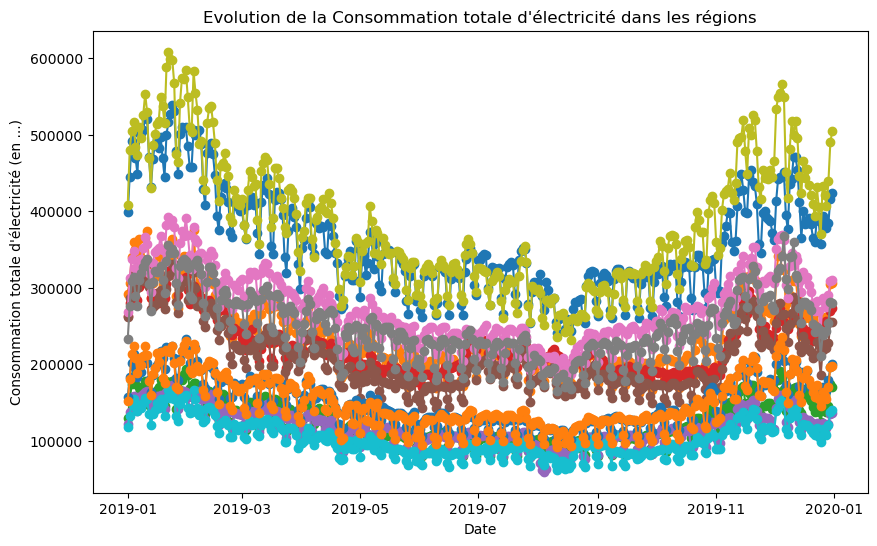

In [178]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['consommation_brute_electricite_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la Consommation totale d'électricité dans les régions")
plt.xlabel('Date')
plt.ylabel("Consommation totale d'électricité (en ...)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()


### Evolution de la température moyenne au cours de l'année

In [ ]:
# Gestion des valeurs extrêmes le cas échéant

En représentant l'évolution simultannée de la température journalière dans chasun des départements, il est constaté qu'à une période donnée, certaines régions sont plus chaudes que d'autres. Toutefois, les périodes de hausse et de baisse des températures sont généralement les mêmes températures dans toutes les régions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


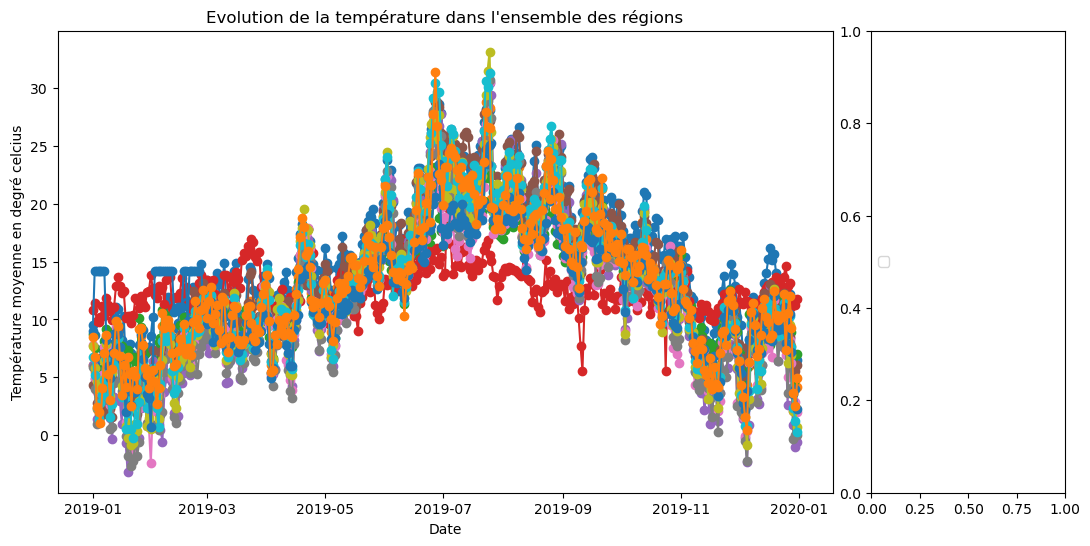

In [173]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['temperature_degre_celcius_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la température dans l'ensemble des régions")
plt.xlabel('Date')
plt.ylabel('Température moyenne en degré celcius')

# Ajout d'une légende
#plt.legend()

# Créer un axe dédié pour la légende
legend_ax = plt.gca().inset_axes([1.05, 0, 0.25, 1])

# Ajouter la légende à l'axe dédié
legend_ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))


# Affichage du graphique
plt.show()

### Evolution de la température minimale au cours de l'année

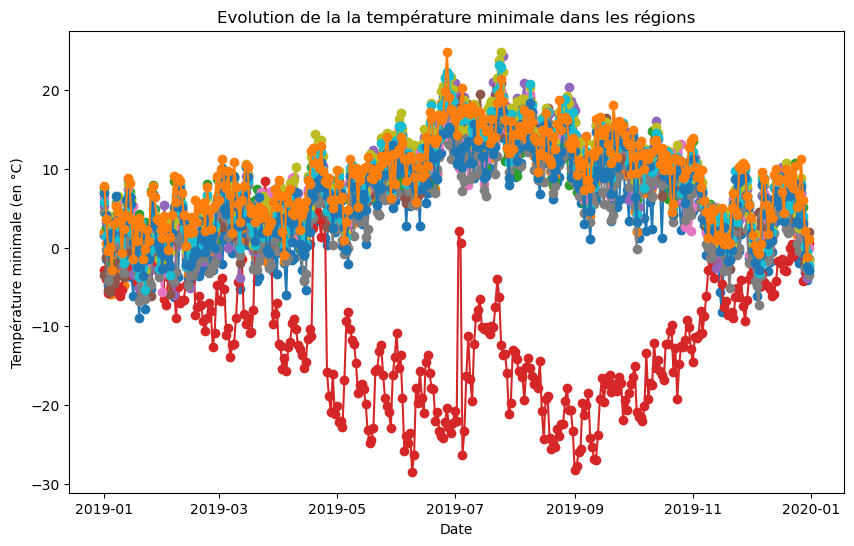

In [176]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['temperature_celcius_min_sur_24h_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la la température minimale dans les régions")
plt.xlabel('Date')
plt.ylabel("Température minimale (en °C)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()

### Evolution de la température maximale au cours de l'année

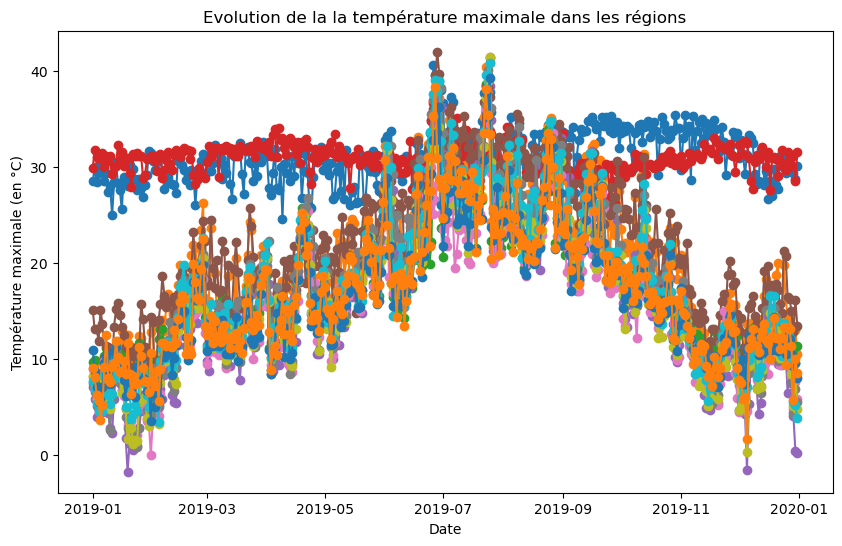

In [179]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['temperature_celcius_max_sur_24h_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la la température maximale dans les régions")
plt.xlabel('Date')
plt.ylabel("Température maximale (en °C)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()

### Evolution de la vitesse moyenne du vent au cours de l'année

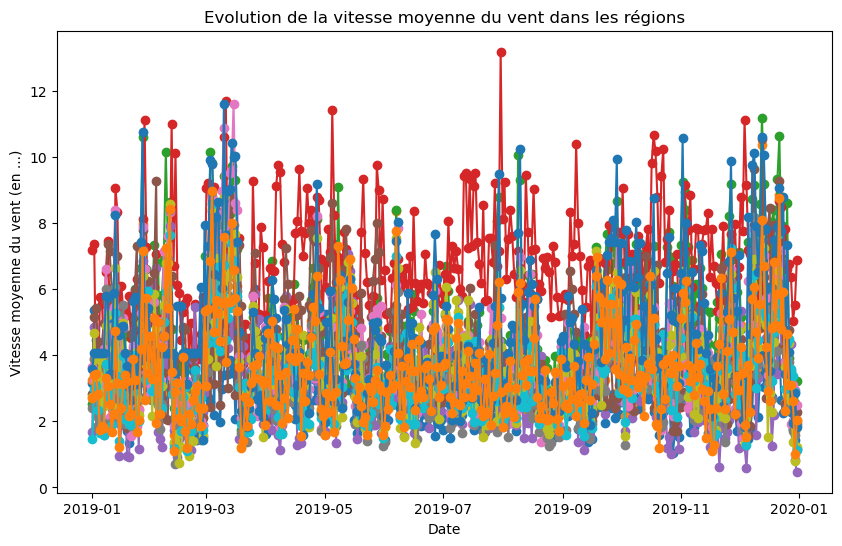

In [180]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['vitesse_vent_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la vitesse moyenne du vent dans les régions")
plt.xlabel('Date')
plt.ylabel("Vitesse moyenne du vent (en ...)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()

### Evolution de la nébulosité totale moyenne au cours de l'année

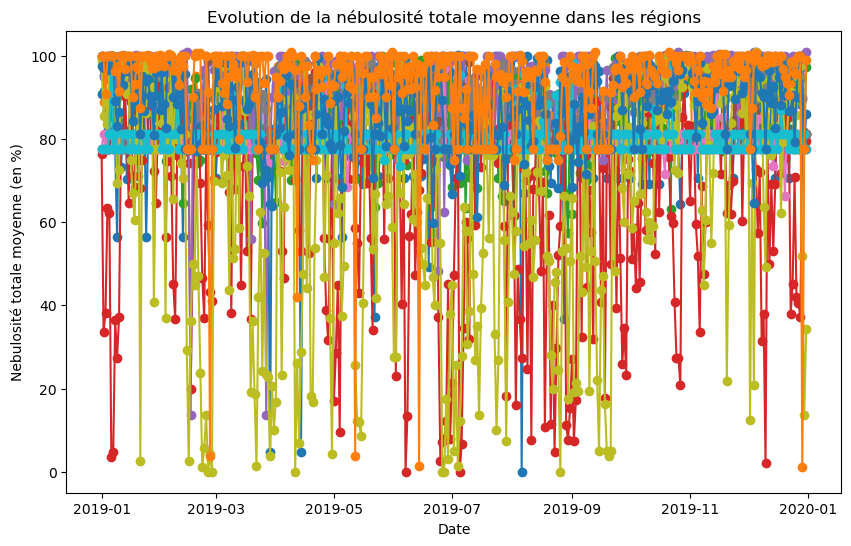

In [181]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['nebulosite_totale_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la nébulosité totale moyenne dans les régions")
plt.xlabel('Date')
plt.ylabel("Nebulosité totale moyenne (en %)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()

### Evolution de la visibilité horizontale moyenne au cours de l'année

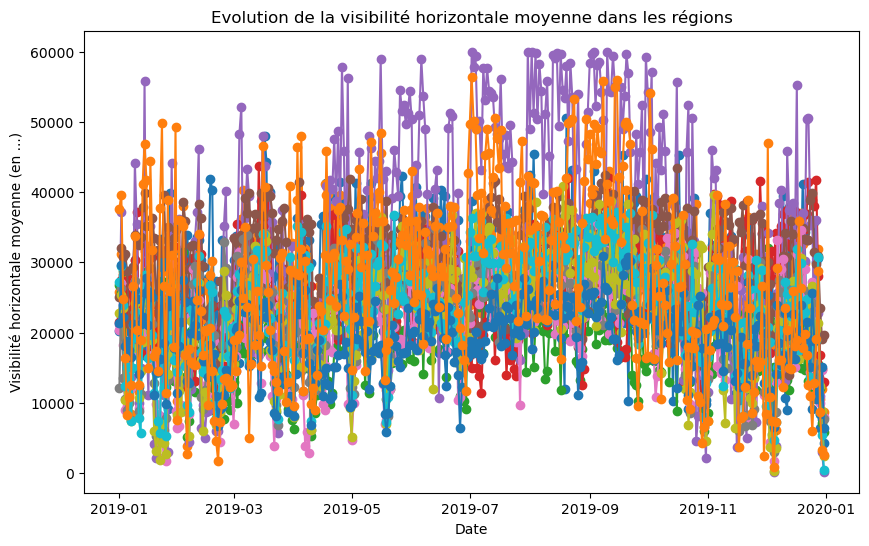

In [183]:
# Création du graphique
plt.figure(figsize=(10, 6))
# Superposition des séries temporelles avec des couleurs différentes pour chaque catégorie
for categorie in base_finale_1['nom_region'].unique():
    plt.plot(base_finale_1[base_finale_1['nom_region'] == categorie]['date'],
             base_finale_1[base_finale_1['nom_region'] == categorie]['visibilite_horizontale_region'],
             label=f'{categorie}',
             marker='o', linestyle='-')

# Ajout des titres et des labels
plt.title("Evolution de la visibilité horizontale moyenne dans les régions")
plt.xlabel('Date')
plt.ylabel("Visibilité horizontale moyenne (en ...)")

# Ajout d'une légende
#plt.legend()

# Affichage du graphique
plt.show()

## Analyse des potentielles liaisons entre la consommation d'électricité et les variables météorologiques

In [135]:

#type(base_finale_1['date'])
#base_finale_1.columns
base_finale_1['date'].max()

Timestamp('2019-12-31 00:00:00')

In [174]:
base_finale_1.columns

Index(['index', 'date', 'code_region', 'nom_region',
       'temperature_degre_celcius_region', 'vitesse_vent_region',
       'nebulosite_totale_region', 'visibilite_horizontale_region',
       'temperature_celcius_min_sur_24h_region',
       'temperature_celcius_max_sur_24h_region', 'jour_ouvre',
       'Statut_du_jour', 'geometry', 'consommation_brute_electricite_region'],
      dtype='object')

In [ ]:
### Evolution de la consommation totale d'électricité au cours de l'année
### Evolution de la température moyenne au cours de l'année
### Evolution de la température minimale au cours de l'année
### Evolution de la température maximale au cours de l'année
### Evolution de la vitesse moyenne du vent au cours de l'année
### Evolution de la nebulosité totale moyenne au cours de l'année
### Evolution de la visibilité horizontale moyenne au cours de l'année

.... à compléter (regarder la fin de la partie preprocessing du cours pour cela)

## Analyse descriptive bivariée